In [293]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import matplotlib.patches as mpatches

# Font dictionaries


title_font = {'family':'arial','weight':'bold','size':20,'color':'black'}
tick_font = {'family':'arial','weight':'normal','size':12,'color':'black'}
axis_label_font = {'family':'arial','weight':'bold','size':14,'color':'black'}







In [294]:
# Cleaning the data set
def clean_transform_extract(csv_file_path, json_file_path, cleaned_csv_file_path):
    '''
    Purpose:
    - Clean: Address errors, duplicates, or NaN/Empty values, if applicable
    - Transform: Convert columns to workable dtype or workable format
    - Extract: Pull relevant data from json df and return it to csv df

    Paramenters:
    - yt_df: the `USvideos.csv` that will serve as the primary df during case study
    - yt_json_df: the `US_category_id.json` that serves as the mechanism for extracting
    category id, name key, value pairs and returning to `yt_df`

    Actions:
    - See comments below 

    Outputs:
    - Cleaned and transformed `yt_df`
    - An array of all unique tags in the `yt_df['tags']` column
    - A dictionary of all `category_id`, `category_name` key, value pairs
    '''
    import pandas as pd
    yt_df = pd.read_csv(csv_file_path)
    yt_json_df = pd.read_json(json_file_path)

    # Converts datetime columns to datetime dtypes based on specific formats
    # Converts `publish_time to UTC datetime format`
    yt_df['publish_time'] = pd.to_datetime(
        arg=yt_df['publish_time'], 
        errors='coerce',
        )
    # Converts `trending_date` to datetime format (`yy-dd-mm`-based)
    yt_df['trending_date'] = pd.to_datetime(
        arg=yt_df['trending_date'], 
        errors='coerce', 
        format='%y.%d.%m',
        )
    
    # Category names
    # Creates a dictionary of category id (keys) and names (values)
    cat_id_name_dict = dict(
        zip(
            yt_json_df['items'].str.get('id').astype(int),
            yt_json_df['items'].str.get('snippet').str.get('title')
            )
        )    
    # Inserts category names into a new column using the dictionary
    # and `category_id` column as a map
    yt_df.insert(
        loc=5, 
        column='category_name', 
        value=yt_df['category_id'].map(cat_id_name_dict)
        )

    # Inserts three new columns based on the `publish_time` column
    # Inserts month column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 1, 
        column='publish_time_month', 
        value=yt_df['publish_time'].dt.month_name()
        )
    # Inserts day of week name column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 2, 
        column='publish_time_day_name', 
        value=yt_df['publish_time'].dt.day_name()
        )
    # Inserts date column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 3, 
        column='publish_time_date', 
        value=yt_df['publish_time'].dt.date
        )

    # Inserts two new columns based on the `trending_date` column
    # Inserts month column
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 1, 
        column='trending_date_month', 
        value=yt_df['trending_date'].dt.month_name()
        )
    # Inserts day of week name column
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 2, 
        column='trending_date_day_name', 
        value=yt_df['trending_date'].dt.day_name()
        )
    
    range_series = (
    yt_df.groupby('video_id')['trending_date'].max()
      - yt_df.groupby('video_id')['trending_date'].min()
        ).dt.days
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 3, 
        column='num_days_trending', 
        value=yt_df['video_id'].map(range_series)
    )

    # Replaces the values in the `tags` column
    # with a list of individual tags as opposed to a single string
    yt_df['tags'] = yt_df['tags'].str.split('|')
    tag_arr = yt_df['tags'].explode().str.strip('"').str.lower().value_counts(ascending=False).drop('[none]')

    yt_df.to_csv(cleaned_csv_file_path, index=False)
   
    # Prints a message containing instructions on what to do next
    print(f"In a separate cell block, execute the following line of code: clean_yt_df = pd.read_csv('{cleaned_csv_file_path}')")
   
    # Returns the tag_dict the dictionary
    return yt_df, tag_arr

print(tag_arr)

tags
funny         4142
comedy        3647
how to        1702
music         1664
pop           1634
              ... 
wrote            1
casinos          1
frances ha       1
greenberg        1
langford         1
Name: count, Length: 51570, dtype: int64


In [295]:

dupe_counts = yt_df["video_id"].value_counts()


print(dupe_counts)


duplicate_rows = yt_df[yt_df["video_id"].isin(dupe_counts.index)]
print(duplicate_rows.sort_values("video_id"))

unique_videos = yt_df.drop_duplicates(subset='video_id')
unique_videos.head()

video_id
j4KvrAUjn6c    30
8h--kFui1JA    29
QBL8IRJ5yHU    29
t4pRQ0jn23Q    29
MAjY8mCTXWk    29
               ..
QDHcA33yT0I     1
6XxA-4Jp7AU     1
GIRJck1pVRA     1
Wpr2WvQn-kg     1
yz7Xq3T0YPs     1
Name: count, Length: 6351, dtype: int64
          video_id trending_date trending_date_month trending_date_day_name  \
39584  -0CMnp02rNY    2018-06-08                June                 Friday   
40208  -0CMnp02rNY    2018-06-11                June                 Monday   
40007  -0CMnp02rNY    2018-06-10                June                 Sunday   
39795  -0CMnp02rNY    2018-06-09                June               Saturday   
39375  -0CMnp02rNY    2018-06-07                June               Thursday   
...            ...           ...                 ...                    ...   
32774  zxwfDlhJIpw    2018-05-05                 May               Saturday   
33637  zxwfDlhJIpw    2018-05-09                 May              Wednesday   
144    zy0b9e40tK8    2017-11-14          

,video_id,trending_date,trending_date_month,trending_date_day_name,trending_date_date,trending_range_days,title,channel_title,category_id,category_name,...,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,November,Tuesday,2017-11-14,6,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,People & Blogs,...,[SHANtell martin],748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,November,Tuesday,2017-11-14,6,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,Entertainment,...,"[last week tonight trump presidency, ""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,November,Tuesday,2017-11-14,6,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,Comedy,...,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,November,Tuesday,2017-11-14,6,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,Entertainment,...,"[rhett and link, ""gmm"", ""good mythical morning...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,November,Tuesday,2017-11-14,5,I Dare You: GOING BALD!?,nigahiga,24,Entertainment,...,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


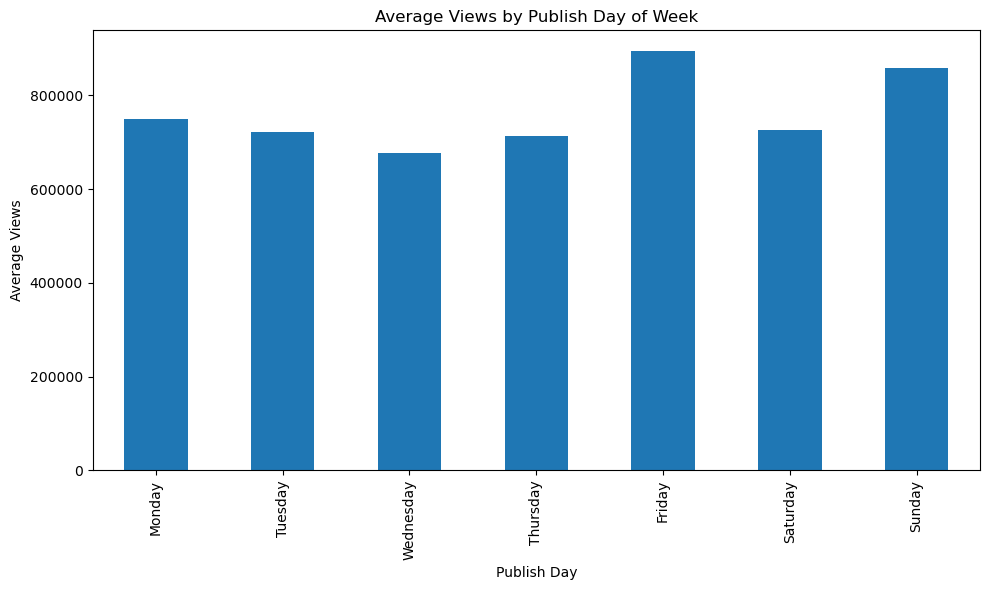

In [296]:
unique_videos = yt_df.drop_duplicates(subset='video_id')
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pop_by_day = (
    unique_videos
      .groupby('publish_time_day_name')['views']
      .mean()
      .reindex(day_order)
)

fig, ax = plt.subplots(figsize=(10,6))
pop_by_day.plot(kind='bar', ax=ax)
ax.set_title('Average Views by Publish Day of Week')
ax.set_xlabel('Publish Day')
ax.set_ylabel('Average Views')
plt.tight_layout()
plt.show()

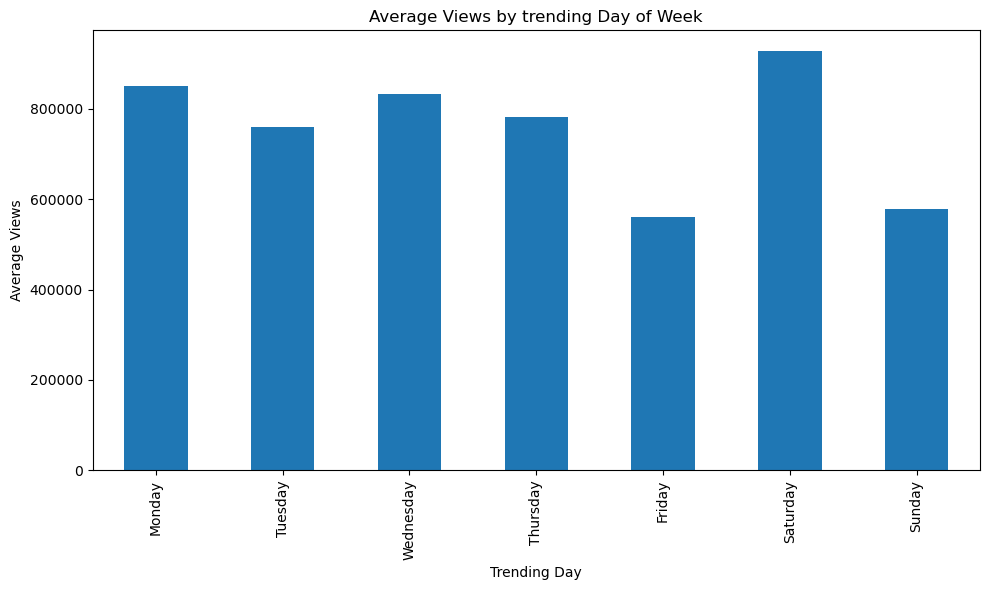

In [297]:
unique_videos = new_yt_df.drop_duplicates(subset='video_id')
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pop_by_day = (
    unique_videos
      .groupby('trending_date_day_name')['views']
      .mean()
      .reindex(day_order)
)
fig, ax = plt.subplots(figsize=(10,6))
pop_by_day.plot(kind='bar', ax=ax)
ax.set_title('Average Views by trending Day of Week')
ax.set_xlabel('Trending Day')
ax.set_ylabel('Average Views')
plt.tight_layout()
plt.show()

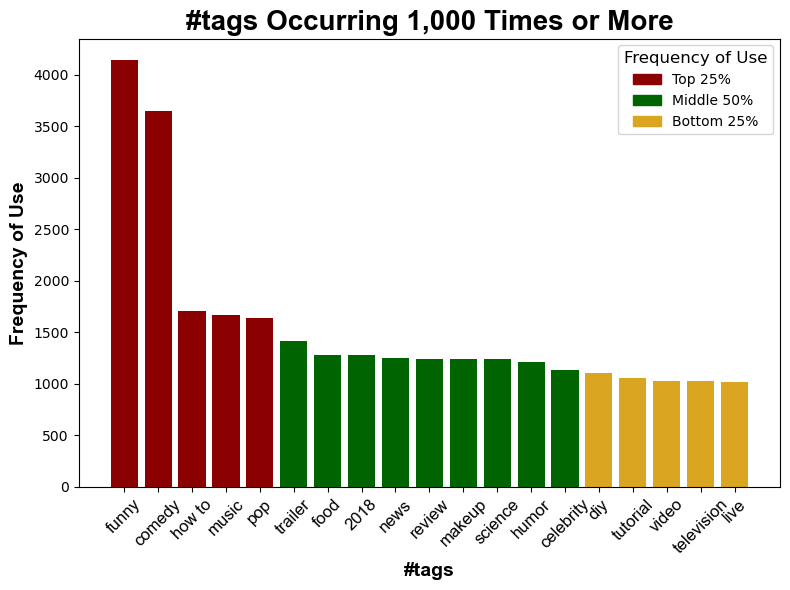

In [298]:
tags_over_1_000 = tag_arr[tag_arr >= 1000]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(tags_over_1_000.index, tags_over_1_000.values)

q1, q3 = np.percentile(tags_over_1_000.values, [25, 75])
for bar in bars:
    h = bar.get_height()
    if h >= q3:
        bar.set_facecolor('darkred')
    elif h > q1:
        bar.set_facecolor('darkgreen')
    else:
        bar.set_facecolor('goldenrod')

ax.set_title('#tags Occurring 1,000 Times or More', fontdict=title_font)
ax.set_xticks(range(len(tags_over_1_000)))
ax.set_xticklabels(tags_over_1_000.index, fontdict=tick_font, rotation=45)
ax.set_xlabel('#tags', fontdict=axis_label_font)
ax.set_ylabel('Frequency of Use', fontdict=axis_label_font)

handles = [
    mpatches.Patch(color='darkred',   label='Top 25%'),
    mpatches.Patch(color='darkgreen', label='Middle 50%'),
    mpatches.Patch(color='goldenrod', label='Bottom 25%')
]

leg = ax.legend(
    handles=handles,
    title='Frequency of Use',
    loc='upper right',
    fontsize='medium',
    title_fontsize='large'
)
leg.get_title().set_color('black')

plt.tight_layout()
plt.show()

/var/folders/h1/_mf1_n2n22l_q790cb3_c2lr0000gp/T/ipykernel_67961/1461070783.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


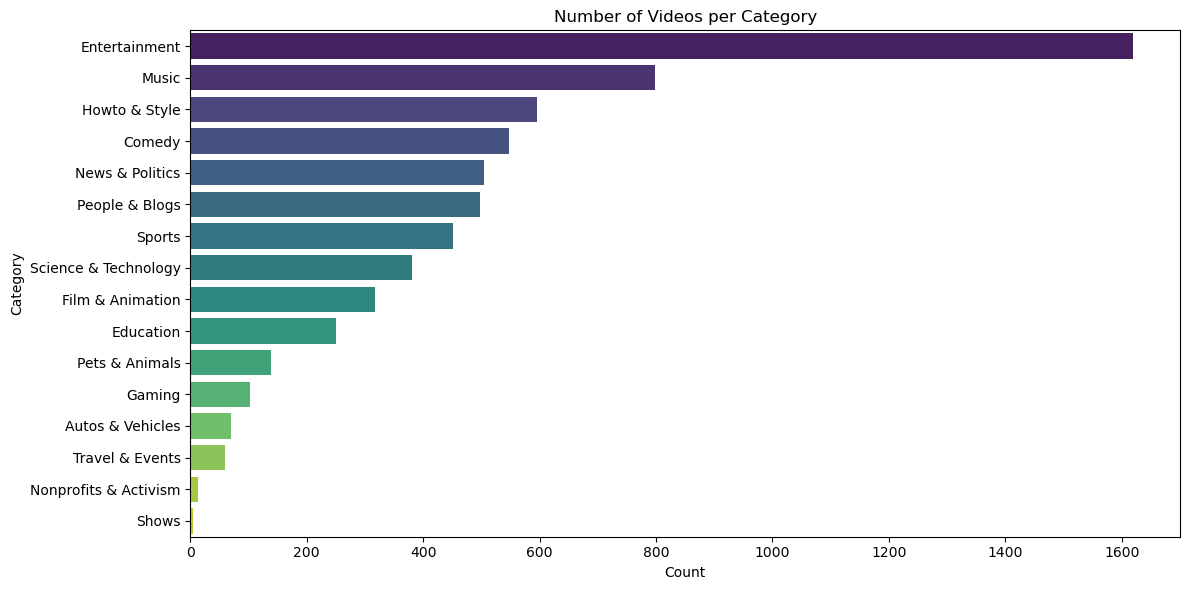

In [299]:
counts = unique_videos["category_name"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(
    y=counts.index,
    x=counts.values,
    palette=sns.color_palette("viridis", len(counts)),
    orient="h",
)
plt.title("Number of Videos per Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


                       total_views  count
category_name                            
Autos & Vehicles          28445164     70
Comedy                   422806173    547
Education                 87994865    250
Entertainment           1322922283   1619
Film & Animation         292697703    318
Gaming                   124819911    103
Howto & Style            281517665    595
Music                   1108709326    799
News & Politics          124950593    505
Nonprofits & Activism     14353032     14
People & Blogs           354958216    498
Pets & Animals            38654401    138
Science & Technology     222042546    380
Shows                      1569435      4
Sports                   374456969    451
Travel & Events           14490662     60
                       total_views  count  views_per_trend
category_name                                             
Music                   1108709326    799     1.387621e+06
Gaming                   124819911    103     1.211844e+06
Nonprofi

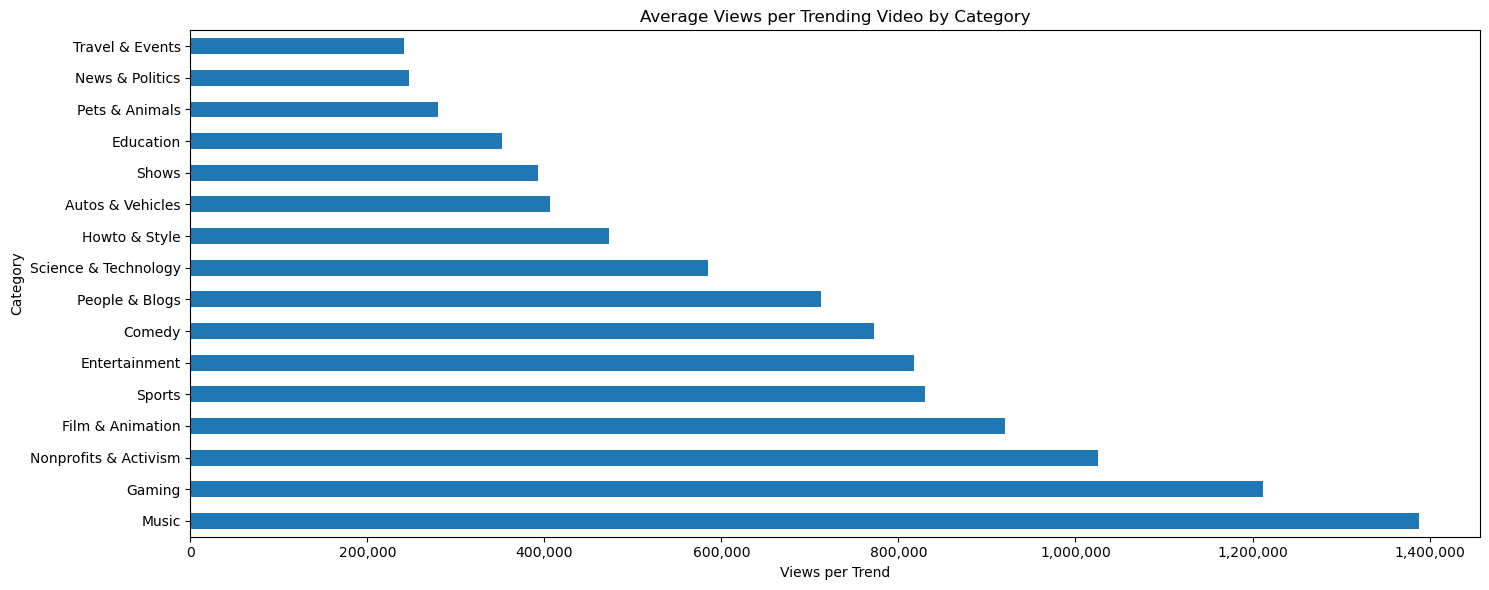

In [300]:
summary = unique_videos.groupby("category_name").agg(
    total_views = ("views", "sum"),
    count       = ("views", "size")
)

print(summary)

summary["views_per_trend"] = summary["total_views"] / summary["count"]
power_summary = summary.sort_values("views_per_trend", ascending=False)

print(power_summary)



fig, ax = plt.subplots(figsize=(15,6))
power_summary["views_per_trend"].plot.barh(ax=ax)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title("Average Views per Trending Video by Category")
ax.set_xlabel("Views per Trend")
ax.set_ylabel("Category")
plt.tight_layout()
plt.show()




/var/folders/h1/_mf1_n2n22l_q790cb3_c2lr0000gp/T/ipykernel_67961/503394548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


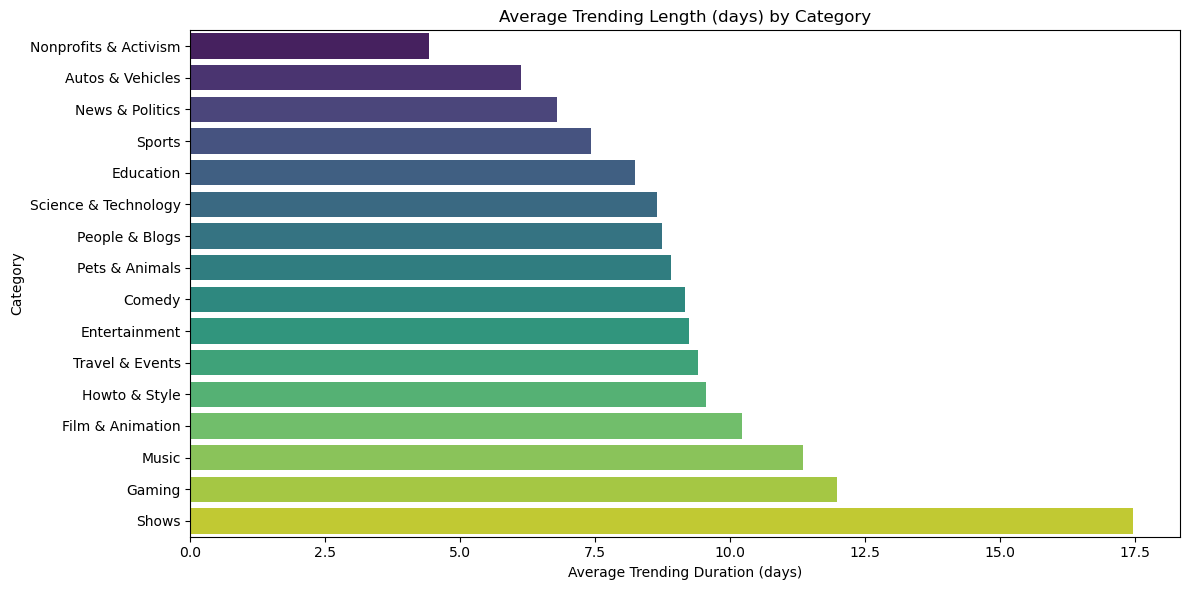

In [305]:
avg_trend_days = (
    yt_df.groupby('category_name')['trending_range_days']
         .mean()
         .sort_values()
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=avg_trend_days.values,
    y=avg_trend_days.index,
    palette='viridis',
    orient='h'
)
plt.xlabel('Average Trending Duration (days)')
plt.ylabel('Category')
plt.title('Average Trending Length (days) by Category')
plt.tight_layout()
plt.show()
